In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile

from qiskit.quantum_info import Operator

import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manag
import qiskit.visualization as qplt
from qiskit.quantum_info import random_statevector
from qiskit.quantum_info import Statevector, state_fidelity

### Decomposing a random 8 qubit unitary

In [2]:
# load the 256×256 unitary
uL = np.loadtxt("uL.csv", delimiter=",")


In [3]:
# build an 8-qubit circuit that implements uL exactly
qc = QuantumCircuit(8)
qc.append( Operator(uL), list(range(8)) )

In [4]:
# now decompose into native gates
qc_synth = transpile(
    qc,
    # basis_gates=['u3','cx'],            # your native gate set
    # optimization_level=0,               # disable the “generic” optimiser
    unitary_synthesis_method='sk',        # use the efficient CSD algorithm
    unitary_synthesis_plugin_config={
        'recursion_degree': 0  # ← set recursion depth to 2
    }
)


In [5]:
print(qc.depth())
print(qc_synth.depth())

1
45062


Simulation results: {'01100110': 1514, '00100110': 1565, '01010001': 1586, '00011100': 1546, '01011011': 1577, '01101100': 1564, '00100100': 1565, '01100001': 1622, '00011011': 1558, '11000001': 6185, '01011110': 1535, '00010110': 1536, '00100011': 1568, '01101001': 1591, '01011001': 1584, '10001001': 6309, '11000110': 6321, '00101001': 1508, '00101100': 1569, '00101011': 1540, '00010001': 1547, '01010110': 1551, '00010011': 1531, '01010011': 1534, '01010100': 1561, '11000011': 6213, '00011110': 1545, '10001110': 6119, '00010100': 1576, '11000100': 6445, '01011100': 1542, '01100011': 1546, '00011001': 1582, '00100001': 1641, '01101110': 1529, '01100100': 1540, '10110011': 6343, '00101110': 1568, '01101011': 1567, '10110100': 6177}


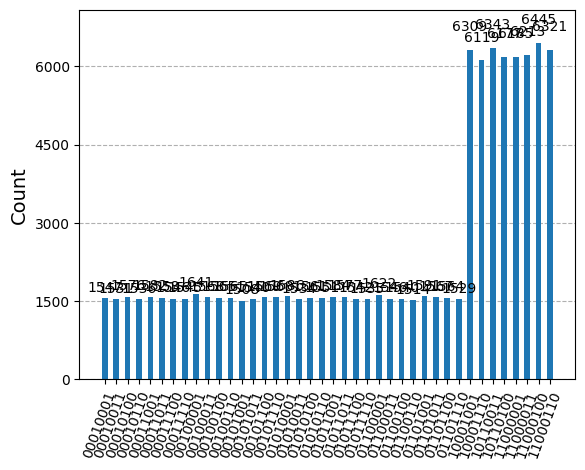

In [6]:
qc.measure_all()
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

job = simulator.run(compiled_circuit, shots=100000)
result = job.result()
counts = result.get_counts()

print("Simulation results:",counts)
qplt.plot_histogram(counts)

In [7]:
uLdg = uL.conj().T
qc_synth.append(Operator(uLdg), list(range(8)))

qc_synth.measure_all()

Simulation results: {'00000000': 100000}


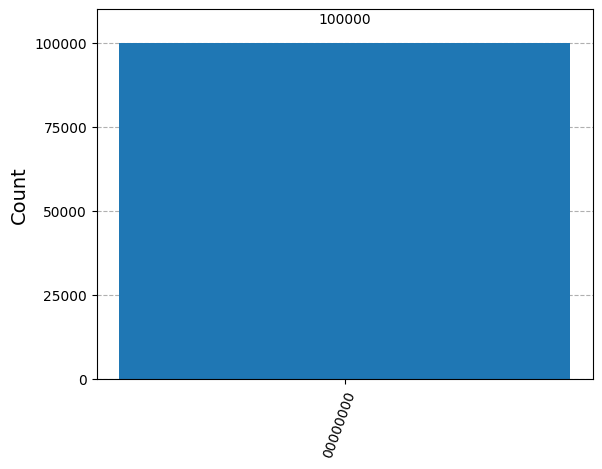

In [8]:
simulator = AerSimulator()
compiled_circuit = transpile(qc_synth, simulator)

job = simulator.run(compiled_circuit, shots=100000)
result = job.result()
counts = result.get_counts()

print("Simulation results:",counts)
qplt.plot_histogram(counts)

In [ ]:
# from qiskit import Aer, transpile

# your two QuantumCircuit objects
circuit_target   = qc
circuit_approx   = qc_synth

# 1. Turn them into statevectors
sv_target = Statevector.from_instruction(circuit_target)
sv_approx = Statevector.from_instruction(circuit_approx)

# 2. Compute fidelity
F = state_fidelity(sv_target, sv_approx)
print(f"Fidelity = {F:.6f}")


In [ ]:
import qiskit
qiskit.transpiler.passes.synthesis.plugin.unitary_synthesis_plugin_names()

In [ ]:
# load the 256×256 unitary
uR = np.loadtxt("uR.csv", delimiter=",")

# build an 8-qubit circuit that implements uL exactly
qcR = QuantumCircuit(8)
qcR.append( Operator(uR), list(range(8)) )

# now decompose into native gates
qcR_opt = qcR.decompose()
# print(qcR_opt)
# print(qc.draw('text'))

In [ ]:
qcR_opt.depth()

### Exploiting the Hopf structure of uL, uR, and decomposing them

In [ ]:
import numpy as np
from math import log2
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator


block_circuits = []
for k, d in enumerate(block_dims, start=1):
    # load the real & imag parts
    Ur = np.loadtxt(f"uL_block_{k}_real.csv", delimiter=",")
    Ui = np.loadtxt(f"uL_block_{k}_imag.csv", delimiter=",")

    # If you got a scalar (shape == ()), make it 1×1
    if Ur.shape == ():
        Ur = np.array([[Ur]])
        Ui = np.array([[Ui]])

    U = Ur + 1j*Ui
    assert U.shape == (d, d)

    
    # build & decompose the k-th block circuit
    n = int(log2(d))
    qc = QuantumCircuit(n, name=f"block_{k}")
    qc.append(Operator(U), list(range(n)))
    block_circuits.append(qc.decompose())


# 1) Read the two real matrices
W_real = np.loadtxt("uL_SchurTransform_W_real.csv", delimiter=",")
W_imag = np.loadtxt("uL_SchurTransform_W_imag.csv", delimiter=",")
W = W_real + 1j * W_imag

print("W.shape =", W.shape)   # should be (256,256)

# 2) Read in each irreducible block (pure-real or pure-complex)
block_dims = np.loadtxt("uL_block_dims.txt", dtype=int)

block_circuits = []
for k, d in enumerate(block_dims, start=1):
    U = np.loadtxt(f"uL_block_{k}.csv", delimiter=",", dtype=complex)
    n = int(log2(d))
    qc = QuantumCircuit(n, name=f"block_{k}")
    qc.append(Operator(U), list(range(n)))
    block_circuits.append(qc.decompose())

# 3) Compile the Schur transform once
schur_qc = QuantumCircuit(8, name="Schur")
schur_qc.append(Operator(W), list(range(8)))
schur_decomp = schur_qc.decompose()

# 4) You’re now ready to assemble your full uL circuit…

### Another decomposition attempt

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator


In [ ]:
# 1. Load the 256×256 unitary from CSV
uL = np.loadtxt("uL.csv", delimiter=",");

In [ ]:
# 2. Reshape into a rank‑4 tensor: (para_in, quantum_in, para_out, quantum_out)
U4 = uL.reshape((4, 64, 4, 64), order='C')



In [ ]:
# 3. Reorder axes so that para‑out, para‑in, quantum‑out, quantum‑in
U4 = np.transpose(U4, (2, 0, 3, 1))



In [ ]:
# 4. Flatten back to 256×256 with new ordering
uL_reordered = U4.reshape((256, 256), order='C')



In [ ]:
# 5. Apply Hopf‑algebra block‑diagonalizing change of basis
# TODO: compute the 64×64 unitary U_reg that diagonalizes the left regular rep of H64
U_reg = np.load("U_reg.npy")  # placeholder for the irreducible basis change
I4 = np.eye(4)
U_full = np.kron(I4, U_reg)
# rows index output, columns input => U_out * uL * U_in^†
uL_transformed = U_full.conj().T.dot(uL_reordered).dot(U_full)



In [ ]:
# 6. Build an 8‑qubit circuit and transpile using native u3 and cx gates
qc = QuantumCircuit(8)
qc.append(Operator(uL_transformed), list(range(8)))
qc_synth = transpile(qc, basis_gates=["u3", "cx"], optimization_level=3)

print(f"Optimized depth: {qc_synth.depth()}")
print(f"Gate counts: {qc_synth.count_ops()}")

### uLafter

In [ ]:
from qiskit.circuit.library import Multiplexer
# load the 256×256 unitary
uLafter = np.loadtxt("uLafter.csv", delimiter=",")

# build an 8-qubit circuit that implements uL exactly
# qcafter = QuantumCircuit(8)
# qcafter.append( Operator(uLafter), list(range(8)) )

blocks = [
    [
      uLafter[a*64:(a+1)*64, b*64:(b+1)*64]
      for b in range(4)
    ]
    for a in range(4)
]

qcafter = QuantumCircuit(8)
# the first 2 qubits are the "para" controls, the last 6 are the "quantum" target
qcafter.append(Multiplexer(blocks), list(range(8)))

# 2) transpile it using CSD-based unitary synthesis
#    (requires Qiskit Terra ≥0.20)
qcafter_synth = transpile(
    qcafter,
    basis_gates=['u3','cx'],            # your native gate set
    optimization_level=0,               # disable the “generic” optimiser
    unitary_synthesis_method='default'      # use the efficient CSD algorithm
)
# print(qc_opt)
# print(qc.draw('text'))

In [ ]:
qcafter_synth.depth()

In [ ]:
from qiskit.circuit import Gate

# 1) make a 6-qubit Gate for each block W_ab
gates = {
  (a,b): Gate(f"W_{a}{b}", num_qubits=6, params=[]).define(  # pseudocode
             lambda qc, _: qc.unitary(Operator(blocks[a][b]), range(6)) )
  for a in range(4) for b in range(4)
}

# 2) build qc that, for each (a,b), does a multi-controlled application of gates[(a,b)]
qc = QuantumCircuit(8)
for a in range(4):
  for b in range(4):
    ctrl_bits = [0,1]        # your 2 para qubits
    tgt_bits  = list(range(2,8))
    qc.append(gates[(a,b)].control(2), ctrl_bits + tgt_bits)

# 3) transpile and let Qiskit collapse the common structure
qc_synth = transpile(qc,
                     basis_gates=["u3","cx"],
                     optimization_level=3)

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit.circuit.library import UnitaryGate

# ──────────────────────────────────────────────────────────────────────────────
# 1) Define placeholder 8-qubit basis-change gates p, s and their daggers
# ──────────────────────────────────────────────────────────────────────────────
p    = Gate('p',    8, [])
s    = Gate('s',    8, [])
p_dg = Gate('p_dg', 8, [])
s_dg = Gate('s_dg', 8, [])

# ──────────────────────────────────────────────────────────────────────────────
# 2) Define your 7-qubit blocks u1, u2 as UnitaryGates so Qiskit can control them
# ──────────────────────────────────────────────────────────────────────────────
I7   = np.eye(2**7)
u1   = UnitaryGate(I7, label='u1')
u2   = UnitaryGate(I7, label='u2')

# turn them into 1-qubit-controlled gates:
cu1  = u1.control(1, ctrl_state='0', label='c0-u1')  # 0-control on qubit 0
cu2  = u2.control(1, ctrl_state='1', label='c1-u2')  # 1-control on qubit 0

# ──────────────────────────────────────────────────────────────────────────────
# 3) Build the 8-qubit circuit
#    Sandwich:  p → s → [0-ctrl u1 + 1-ctrl u2] → s† → p†
# ──────────────────────────────────────────────────────────────────────────────
qc = QuantumCircuit(8)

# a) basis change: p, then s
qc.append(p,    qc.qubits)
qc.append(s,    qc.qubits)

# b) 0-controlled u1 on qubits 1–7 (control = q0)
qc.x(0)
qc.append(cu1, [0] + list(range(1, 8)))
qc.x(0)

# c) 1-controlled u2 on qubits 1–7 (control = q0)
qc.append(cu2, [0] + list(range(1, 8)))

# d) undo basis: s†, then p†
qc.append(s_dg, qc.qubits)
qc.append(p_dg, qc.qubits)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Draw the circuit (requires matplotlib)
# ──────────────────────────────────────────────────────────────────────────────
qc.draw("mpl")


In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

# ─── 1) Build unitaries ────────────────────────────────────────────────────────
I8 = np.eye(2**8)
I7 = np.eye(2**7)
I6 = np.eye(2**6)

# Outer basis-change on all 8 qubits
p    = UnitaryGate(I8, label='p')
s    = UnitaryGate(I8, label='s')
p_dg = UnitaryGate(I8, label='p†')
s_dg = UnitaryGate(I8, label='s†')

# Inner basis-change on qubits 1–7 (shared)
p1    = UnitaryGate(I7, label='p1')
s1    = UnitaryGate(I7, label='s1')
p1_dg = UnitaryGate(I7, label='p1†')
s1_dg = UnitaryGate(I7, label='s1†')

# Final blocks on qubits 2–7
u11 = UnitaryGate(I6, label='u11')
u12 = UnitaryGate(I6, label='u12')
u21 = UnitaryGate(I6, label='u21')
u22 = UnitaryGate(I6, label='u22')

# ─── 2) Assemble the 8-qubit circuit ──────────────────────────────────────────
qc = QuantumCircuit(8)

# A) Outer basis: p → s
qc.append(p,    range(8))
qc.append(s,    range(8))

# B) Inner basis on qubits 1–7
qc.append(p1,   range(1,8))
qc.append(s1,   range(1,8))

# C) 4-way multiplexed block on q2–q7, controlled by (q0,q1):
#      ctrl_state=0 → '00', 1→'01', 2→'10', 3→'11'
for block, state in [(u11,0),(u12,1),(u21,2),(u22,3)]:
    qc.append(
        block.control(2, ctrl_state=state, label=f"cc-{block.label}"),
        [0,1] + list(range(2,8))
    )

# D) Undo inner basis: s1† → p1†
qc.append(s1_dg, range(1,8))
qc.append(p1_dg, range(1,8))

# E) Undo outer basis: s† → p†
qc.append(s_dg, range(8))
qc.append(p_dg, range(8))

# ─── 3) Draw! ────────────────────────────────────────────────────────────────
qc.draw("mpl")


In [ ]:
#!/usr/bin/env python3
"""
diagonalize_uL.py

Load a 256×256 complex matrix uL, diagonalize it, and save the spectrum.
"""

import numpy as np
from scipy.linalg import eig
import argparse
import os

def main():
    # p = argparse.ArgumentParser(description="Diagonalize a 256×256 matrix uL")
    # p.add_argument(
    #     "--input",
    #     "-i",
    #     required=True,
    #     help="Path to your uL matrix file (.npy or .csv)"
    # )
    # p.add_argument(
    #     "--out-dir",
    #     "-o",
    #     default=".",
    #     help="Directory to save eigenvalues and eigenvectors"
    # )
    # args = p.parse_args()

    # 1) Load uL
    # fname = args.input
    # if fname.endswith(".npy"):
    #     uL = np.load(fname)
    # elif fname.endswith(".csv") or fname.endswith(".txt"):
    #     # assumes two columns per entry, real and imag, or a single complex column?
    #     # simplest is a pure-complex CSV: "a+bi"
    #     uL = np.loadtxt(fname, delimiter=",", dtype=complex)
    # else:
    #     raise ValueError("Unsupported file type: " + fname)

    uL = np.loadtxt("uL.csv", delimiter=",", dtype = complex)

    # sanity check
    if uL.shape != (256, 256):
        raise ValueError(f"Expected uL of shape (256,256), got {uL.shape}")

    # 2) Diagonalize
    #    since uL is unitary (in general not Hermitian), use eig()
    print("Diagonalizing uL (this may take a few seconds)...")
    vals, vecs = eig(uL)

    # 3) Sort by phase (argument) of each eigenvalue
    #    so the blocks of U appear in order of increasing angle
    phases = np.angle(vals)
    sort_idx = np.argsort(phases)
    vals_sorted = vals[sort_idx]
    vecs_sorted = vecs[:, sort_idx]

    # 4) Save results
    # os.makedirs(args.out_dir, exist_ok=True)
    # vals_path = os.path.join(args.out_dir, "uL_eigenvalues.npy")
    # vecs_path = os.path.join(args.out_dir, "uL_eigenvectors.npy")
    # np.save(vals_path, vals_sorted)
    # np.save(vecs_path, vecs_sorted)

    # print(f"Done. Eigenvalues → {vals_path}")
    # print(f"      Eigenvectors → {vecs_path}")
    # print("Example: first 10 eigenvalues:")
    # for i, v in enumerate(vals_sorted[:10]):
    #     print(f"  #{i:02d}: {v:.6f}  (phase {np.angle(v):.3f} rad)")
    return (vals, vecs), (vals_sorted, vecs_sorted)

if __name__ == "__main__":
    (a, b), (c, d) = main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# — assume you’ve already loaded and diagonalized uL into
#    vals:  (256,) complex array of eigenvalues
#    vecs:  (256,256) complex array of eigenvectors,
#           with vecs[:,k] the k-th eigenvector

# 1) Scatter the eigenvalues in the complex plane
plt.figure()
plt.scatter(np.real(a), np.imag(a))
plt.xlabel("Re(eigenvalue)")
plt.ylabel("Im(eigenvalue)")
plt.title("uL eigenvalues on the complex plane")
plt.axis("equal")              # keep aspect ratio so the unit circle looks round

# 2) Histogram of eigenvalue **phases** (angles)
plt.figure()
plt.hist(np.angle(a), bins=50)
plt.xlabel("Phase (radians)")
plt.ylabel("Count")
plt.title("Histogram of eigenvalue phases")

# 3) Pick one eigenvector (say k=0) and plot its **component magnitudes**
k = 0
v = b[:, k]
plt.figure()
plt.plot(np.abs(v))
plt.xlabel("Vector index (0…255)")
plt.ylabel("Magnitude |v_i|")
plt.title(f"Eigenvector #{k}: component magnitudes")

# 4) Likewise, plot its **phases**
plt.figure()
plt.plot(np.angle(v))
plt.xlabel("Vector index (0…255)")
plt.ylabel("Phase (radians)")
plt.title(f"Eigenvector #{k}: component phases")

# 5) (Optional) If you want to see the 4×64 structure as a heatmap:
#    reshape the vector according to ancilla × physical:
v_grid = v.reshape(4, 64)
plt.figure()
plt.imshow(np.abs(v_grid), aspect="auto")
plt.xlabel("Physical index α (0…63)")
plt.ylabel("Ancilla index a (0…3)")
plt.title(f"Eigenvector #{k}: |v[a,α]| heatmap")
plt.colorbar(label="Magnitude")

plt.show()


In [ ]:
import numpy as np

# 1) Assemble S and D
S = d            # shape: (256,256), columns are eigenvectors
D = np.diag(c)    # shape: (256,256), diag = eigenvalues

# 2) Verify orthonormality (since uL is unitary,
#    its eigenvectors should be orthonormal):
assert np.allclose(S.conj().T @ S, np.eye(256), atol=1e-8)

# 3) Check diagonalization:
L = S.conj().T @ uL @ S
assert np.allclose(L, D, atol=1e-8)

# 4) …and you’re done.  L (or D) is your diagonal uL in the new basis.
